# GPU-accelerated FBP with ASTRA

In [1]:
# IMPORTS
import gc
from fbp_fns import *
import sys
sys.path.append('../')

In [2]:
# # GARBAGE COLLECTION
# if 'im' in globals():
#     del im
# if 'reconstruction_fbp' in globals():
#     del reconstruction_fbp
del im
del reconstruction_fbp
gc.collect()

NameError: name 'im' is not defined

Loaded 400 projections, dimensions ((1392, 1040))


Reconstructing slices:   0%|                                                                     | 0/5 [00:00<?, ?it/s]

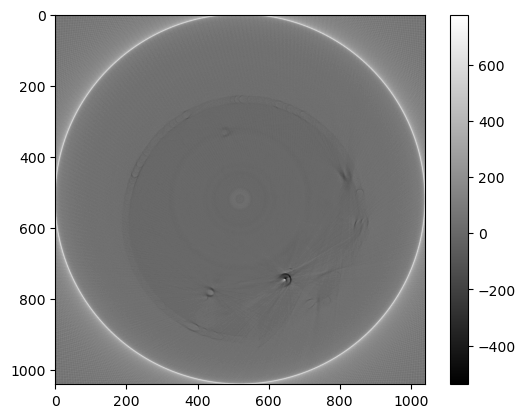

Reconstructing slices:  20%|████████████▏                                                | 1/5 [00:00<00:02,  1.55it/s]

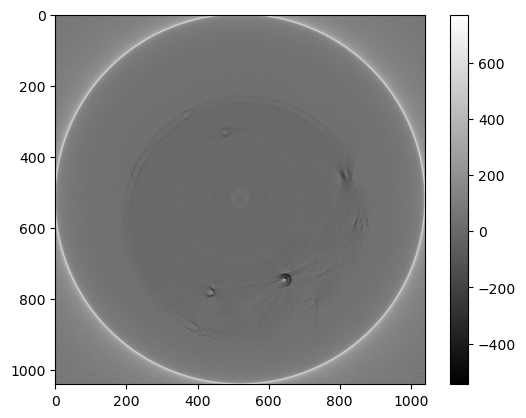

Reconstructing slices:  40%|████████████████████████▍                                    | 2/5 [00:01<00:01,  2.09it/s]

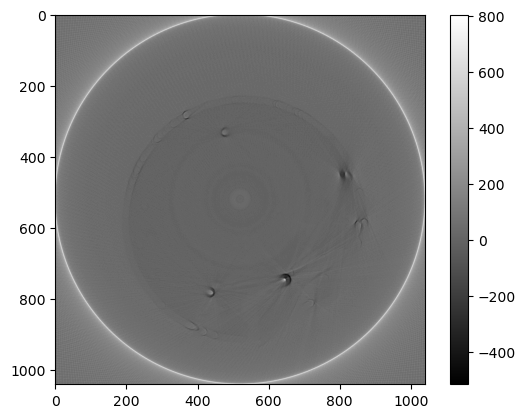

Reconstructing slices:  60%|████████████████████████████████████▌                        | 3/5 [00:01<00:00,  2.28it/s]

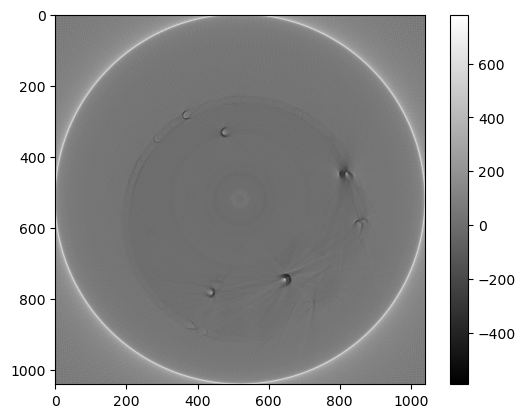

Reconstructing slices:  80%|████████████████████████████████████████████████▊            | 4/5 [00:01<00:00,  2.47it/s]

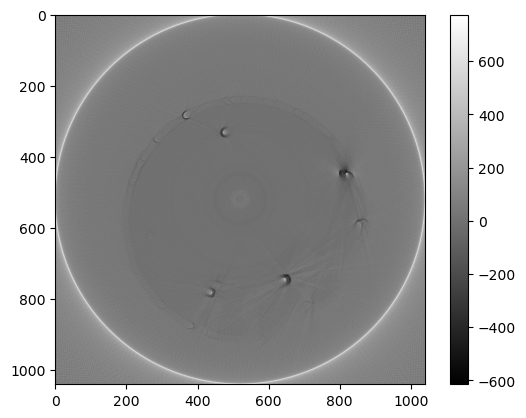

Reconstructing slices: 100%|█████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.35it/s]


In [3]:
# SINGLE IMAGE

PATH_TO_IMAGE = \
    r'D:\MSci_Project\1_Data\2022-12-01 broken phantom\1_2\1_2_MMStack_Pos0.ome.tif'
output_dir = '2022-12-01 broken phantom brightfield'
bead_row = 1216

im = io.imread(PATH_TO_IMAGE)
print(f'Loaded {im.shape[0]} projections, dimensions ({im.shape[1:]})')
# aligned = align(im, bead_row)
# recon = reconstruct(im, output_dir)
im = im[:, 755:760, :]
reconstruction_fbp = run_fbp(im, output_dir, 65535, progbar=True)

In [ ]:
plt.imshow(reconstruction_fbp[45])

In [ ]:
# # FOCAL SCAN

# PATHS_TO_IMAGES = [r'D:\MSci_Project\1_Data\2023-03-01\focal scan\2023-03-01 fd infocus\MMStack_Pos0.ome.tif',
#                   r'D:\MSci_Project\1_Data\2023-03-01\focal scan\2023-03-01 fd -750um\MMStack_Pos0.ome.tif',
#                   r'D:\MSci_Project\1_Data\2023-03-01\focal scan\2023-03-01 fd -1500um\MMStack_Pos0.ome.tif',
#                   r'D:\MSci_Project\1_Data\2023-03-01\focal scan\2023-03-01 fd -2250um\MMStack_Pos0.ome.tif']
# output_dir = '2023-03-01 focal scan'
# bead_row = 626

# im = io.imread(PATHS_TO_IMAGES[0]) // len(PATHS_TO_IMAGES)
# for path in PATHS_TO_IMAGES[1:]:
#     im += io.imread(path) // len(PATHS_TO_IMAGES)
# print(f'Loaded {im.shape[0]} projections, dimensions ({im.shape[1:]})')
# aligned = align(im, bead_row)
# recon = reconstruct(aligned, output_dir)

In [ ]:
# # MULTIPLE IMAGES

# PATHS_TO_IMAGES = [r'D:\MSci_Project\1_Data\2023-03-01\focal scan\2023-03-01 fd infocus\MMStack_Pos0.ome.tif',
#                   r'D:\MSci_Project\1_Data\2023-03-01\focal scan\2023-03-01 fd -750um\MMStack_Pos0.ome.tif',
#                   r'D:\MSci_Project\1_Data\2023-03-01\focal scan\2023-03-01 fd -1500um\MMStack_Pos0.ome.tif',
#                   r'D:\MSci_Project\1_Data\2023-03-01\focal scan\2023-03-01 fd -2250um\MMStack_Pos0.ome.tif']
# output_dirs = ['2023-03-01 infocus', '2023-03-01 -750um', '2023-03-01 -1500um', '2023-03-01 -2250um']
# bead_row = 626

# for PATH_TO_IMAGE, output_dir in zip(PATHS_TO_IMAGES, output_dirs):
#     im = io.imread(PATH_TO_IMAGE)
#     print(f'Loaded {im.shape[0]} projections, dimensions ({im.shape[1:]})')
#     aligned = align(im, bead_row)
#     recon = reconstruct(aligned, output_dir)
#     if 'im' in globals():
#         del im
#     if 'reconstruction_fbp' in globals():
#         del reconstruction_fbp
#     _ = gc.collect()